In [50]:
import cv2
from collections import Counter 

In [174]:
from functools import partial
import matplotlib.pyplot as plt

# from readTFRecords import *

# import tensorflow_hub as hub
# from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import EfficientNetB0


import tensorflow as tf
from tensorflow import keras
import re
import numpy as np
import pandas as pd

from functools import partial

IMAGE_SIZE = (512, 512)
AUTOTUNE = tf.data.experimental.AUTOTUNE
CLASSES = ['0', '1', '2', '3', '4']
NUM_CLASSES = len(CLASSES)

def read_tfrecord(example, labeled=True):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    }

    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = decode_image(example["image"])
    
    if labeled:
        label = tf.cast(example["target"], tf.int32)
        image_name = tf.cast(example["image_name"], tf.string)
        return image, label, image_name
    return image

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32)# / 255.0
    return image
    
    
    
def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=True), num_parallel_calls=AUTOTUNE)
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

# One-hot / categorical encoding
# Resize

def input_preprocess(image, label,image_name):
    image = tf.image.resize(image, size=IMAGE_SIZE)
#     image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=255)
#     image = tf.image.rgb_to_yuv(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label,image_name


def get_training_dataset(FILENAMES, BATCH_SIZE=12):
    dataset = load_dataset(FILENAMES, labeled=True)  
    dataset = dataset.map(input_preprocess, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
#     dataset = dataset.map(cutmix)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_validation_dataset(FILENAMES, BATCH_SIZE=12):
    dataset = load_dataset(FILENAMES, labeled=True)
    dataset = dataset.map(input_preprocess, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset



from sklearn.model_selection import train_test_split

# AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = "../input/train_tfrecords"

FILENAMES = tf.io.gfile.glob(GCS_PATH + "/*tfrec")
split_ind = int(0.9 * len(FILENAMES))
# TRAINING_FILENAMES, VALID_FILENAMES = FILENAMES[:split_ind], FILENAMES[split_ind:]

# TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(FILENAMES, test_size=0.2, random_state=420)

# TRAINING_FILENAMES = ['gs://kds-3a224514a454fd9aa3d169e4b992b270639f50cb2562afc9a7f30028/train_tfrecords/ld_train04-1338.tfrec', 'gs://kds-3a224514a454fd9aa3d169e4b992b270639f50cb2562afc9a7f30028/train_tfrecords/ld_train05-1338.tfrec', 'gs://kds-3a224514a454fd9aa3d169e4b992b270639f50cb2562afc9a7f30028/train_tfrecords/ld_train06-1338.tfrec', 'gs://kds-3a224514a454fd9aa3d169e4b992b270639f50cb2562afc9a7f30028/train_tfrecords/ld_train07-1338.tfrec', 'gs://kds-3a224514a454fd9aa3d169e4b992b270639f50cb2562afc9a7f30028/train_tfrecords/ld_train08-1338.tfrec', 'gs://kds-3a224514a454fd9aa3d169e4b992b270639f50cb2562afc9a7f30028/train_tfrecords/ld_train09-1338.tfrec', 'gs://kds-3a224514a454fd9aa3d169e4b992b270639f50cb2562afc9a7f30028/train_tfrecords/ld_train10-1338.tfrec', 'gs://kds-3a224514a454fd9aa3d169e4b992b270639f50cb2562afc9a7f30028/train_tfrecords/ld_train11-1338.tfrec', 'gs://kds-3a224514a454fd9aa3d169e4b992b270639f50cb2562afc9a7f30028/train_tfrecords/ld_train12-1338.tfrec', 'gs://kds-3a224514a454fd9aa3d169e4b992b270639f50cb2562afc9a7f30028/train_tfrecords/ld_train13-1338.tfrec', 'gs://kds-3a224514a454fd9aa3d169e4b992b270639f50cb2562afc9a7f30028/train_tfrecords/ld_train14-1338.tfrec', 'gs://kds-3a224514a454fd9aa3d169e4b992b270639f50cb2562afc9a7f30028/train_tfrecords/ld_train15-1327.tfrec']
# VALID_FILENAMES = ['gs://kds-3a224514a454fd9aa3d169e4b992b270639f50cb2562afc9a7f30028/train_tfrecords/ld_train00-1338.tfrec', 'gs://kds-3a224514a454fd9aa3d169e4b992b270639f50cb2562afc9a7f30028/train_tfrecords/ld_train01-1338.tfrec', 'gs://kds-3a224514a454fd9aa3d169e4b992b270639f50cb2562afc9a7f30028/train_tfrecords/ld_train02-1338.tfrec', 'gs://kds-3a224514a454fd9aa3d169e4b992b270639f50cb2562afc9a7f30028/train_tfrecords/ld_train03-1338.tfrec']

TRAINING_FILENAMES = ['../input/train_tfrecords/ld_train04-1338.tfrec', '../input/train_tfrecords/ld_train05-1338.tfrec', '../input/train_tfrecords/ld_train06-1338.tfrec', '../input/train_tfrecords/ld_train07-1338.tfrec', '../input/train_tfrecords/ld_train08-1338.tfrec', '../input/train_tfrecords/ld_train09-1338.tfrec', '../input/train_tfrecords/ld_train10-1338.tfrec', '../input/train_tfrecords/ld_train11-1338.tfrec', '../input/train_tfrecords/ld_train12-1338.tfrec', '../input/train_tfrecords/ld_train13-1338.tfrec', '../input/train_tfrecords/ld_train14-1338.tfrec', '../input/train_tfrecords/ld_train15-1327.tfrec']
VALID_FILENAMES = ['../input/train_tfrecords/ld_train00-1338.tfrec', '../input/train_tfrecords/ld_train01-1338.tfrec', '../input/train_tfrecords/ld_train02-1338.tfrec', '../input/train_tfrecords/ld_train03-1338.tfrec']

TEST_FILENAMES = tf.io.gfile.glob("../input/test_tfrecords/*tfrec")
print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))
print("Test TFRecord Files:", len(TEST_FILENAMES))

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

print('Dataset: {} training images, {} validation images, {} (unlabeled) test images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Train TFRecord Files: 12
Validation TFRecord Files: 4
Test TFRecord Files: 1
Dataset: 16045 training images, 5352 validation images, 1 (unlabeled) test images


In [175]:
VALID_FILENAMES = ['../input/recreate_train_tfrecords/Id_train01-1070.tfrec']

In [140]:
BATCH_SIZE = 12
EPOCHS = 30

In [141]:
from tensorflow.keras.experimental import CosineDecay
import efficientnet.keras as eff

decay_steps = int(round(NUM_TRAINING_IMAGES/BATCH_SIZE))*EPOCHS
cosine_decay = CosineDecay(initial_learning_rate=1e-4, decay_steps=decay_steps, alpha=0.3)

from keras.backend import sigmoid

class SwishActivation(tf.keras.layers.Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
# from tf.keras.layers import Activation
get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
#     x = data_augmentation_layers(inputs)
#     model = tf.keras.applications.EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
model = eff.EfficientNetB5(include_top=False, input_tensor=inputs, weights=None)


# Freeze the pretrained weights
# model.trainable = False

# Rebuild top
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.BatchNormalization()(x)

top_dropout_rate = 0.1
#     x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)

x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(swish_act)(x)
#     x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(swish_act)(x)

outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")

loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.4)
#     loss = tf.keras.losses.CategoricalCrossentropy()

model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(cosine_decay), 
          metrics=["accuracy"])

In [6]:
model = tf.keras.models.load_model('/home/usmanr/Downloads/EfficientNetB5_smooting.h5')

In [176]:
train_dataset = get_validation_dataset(VALID_FILENAMES, BATCH_SIZE=120)

In [177]:
for image, label, filename in train_dataset.take(1):
    pass

In [178]:
image.shape

TensorShape([120, 512, 512, 3])

In [182]:
filename[1]

<tf.Tensor: shape=(), dtype=string, numpy=b'../input/train_images/1018433055.jpg'>

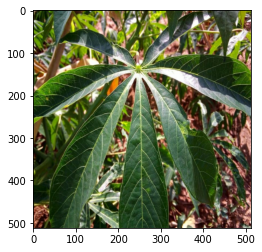

In [181]:
plt.imshow(image[1]/255.0)

In [13]:
# for _ in range(4279//20):
labels = []
preds = []
filenames = []

i = 1
for image, label, filename in train_dataset.take(45):
    labels+=label.numpy().tolist()
    pred = model.predict(image)
    preds+=pred.tolist()
    filenames+=filename.numpy().tolist()
    print(i)
    i+=1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


In [14]:
print(len(filenames))
print(len(set(filenames)))

5352
5352


In [15]:
from sklearn.metrics import accuracy_score

In [16]:
y_label=[np.argmax(y) for y in labels]
y_pred=[np.argmax(y) for y in preds]

In [17]:
accuracy_score(y_label, y_pred)

0.8920029895366218

In [56]:
names_of_disease = pd.read_json('../input/label_num_to_disease_map.json', typ='series')
names_of_disease = names_of_disease.to_dict()

In [57]:
names_of_disease

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [58]:
breaking_point = 0
mixed_precision = []
bad_labels = []

for i in range(len(preds)):
    if np.max(preds[i]) < 0.6:
        print(filenames[i])
        mixed_precision.append(filenames[i].decode("utf-8"))
        bad_labels.append(names_of_disease[np.argmax(labels[i])])
        
        breaking_point+=1
#     if breaking_point > 10:
#         break

b'100042118.jpg'
b'1000015157.jpg'
b'1000910826.jpg'
b'1001320321.jpg'
b'1001723730.jpg'
b'1003218714.jpg'
b'1004826518.jpg'
b'1005200906.jpg'
b'100533489.jpg'
b'1007196516.jpg'
b'1008142548.jpg'
b'1009361983.jpg'
b'1009431532.jpg'
b'1010806468.jpg'
b'1011422445.jpg'
b'1011571614.jpg'
b'1011602291.jpg'
b'1011858443.jpg'
b'1011909285.jpg'
b'1012305013.jpg'
b'1012426959.jpg'
b'101253257.jpg'
b'1012623980.jpg'
b'1014332426.jpg'
b'1014365825.jpg'
b'1015143489.jpg'
b'1015749198.jpg'
b'1016027375.jpg'
b'1016334938.jpg'
b'1016415263.jpg'
b'10169000.jpg'
b'1017667711.jpg'
b'1017827385.jpg'
b'1018973237.jpg'
b'1020387881.jpg'
b'102039365.jpg'
b'1021655183.jpg'
b'1021758544.jpg'
b'1023663951.jpg'
b'1024067372.jpg'
b'1024089865.jpg'
b'1024504187.jpg'
b'102485576.jpg'
b'1024995071.jpg'
b'1027796931.jpg'
b'1028629473.jpg'
b'1030448520.jpg'
b'1032082353.jpg'
b'1032629824.jpg'
b'1033403106.jpg'
b'1034219276.jpg'
b'1032383932.jpg'
b'1034548842.jpg'
b'1034735631.jpg'
b'1036380403.jpg'
b'1040156603.jpg'

b'1706070292.jpg'
b'1706807152.jpg'
b'1707820452.jpg'
b'170814157.jpg'
b'1708593214.jpg'
b'1708792236.jpg'
b'1709404074.jpg'
b'1709691411.jpg'
b'170892269.jpg'
b'1708910636.jpg'
b'1710044268.jpg'
b'1712458333.jpg'
b'1712961040.jpg'
b'1711803773.jpg'
b'1712397585.jpg'
b'1714701345.jpg'
b'1714696851.jpg'
b'1716263265.jpg'
b'1716516140.jpg'
b'1718223523.jpg'
b'1717047149.jpg'
b'1716118009.jpg'
b'1718658976.jpg'
b'1719831117.jpg'
b'1720773250.jpg'
b'1722033032.jpg'
b'1720212686.jpg'
b'1722175051.jpg'
b'1722781074.jpg'
b'172324679.jpg'
b'1725598881.jpg'
b'1722126168.jpg'
b'1727150436.jpg'
b'1727205281.jpg'
b'1728004537.jpg'
b'172872674.jpg'
b'1729891245.jpg'
b'1730472510.jpg'
b'1731589806.jpg'
b'1731652110.jpg'
b'1733574271.jpg'
b'1733650338.jpg'
b'1734625164.jpg'
b'1734635287.jpg'
b'1734198747.jpg'
b'1735838200.jpg'
b'1736063036.jpg'
b'1737787955.jpg'
b'1738379259.jpg'
b'173864450.jpg'
b'1739864126.jpg'
b'1739927380.jpg'
b'1740920965.jpg'
b'1739769852.jpg'
b'1740309612.jpg'
b'1742921296.jp

In [68]:
len(bad_labels)

1314

In [59]:
[ (i,bad_labels.count(i)) for i in set(bad_labels) ]

[('Cassava Green Mottle (CGM)', 239),
 ('Healthy', 333),
 ('Cassava Brown Streak Disease (CBSD)', 228),
 ('Cassava Mosaic Disease (CMD)', 310),
 ('Cassava Bacterial Blight (CBB)', 204)]

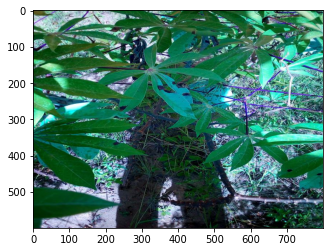

In [29]:
image = cv2.imread('../input/train_images/' + mixed_precision[1] )
plt.imshow(image)

In [22]:
yuv_mixed = '100042118.jpg,1000015157.jpg,1000723321.jpg,1001320321.jpg,1001723730.jpg,1003218714.jpg,1003442061.jpg,1003888281.jpg,1003298598.jpg,1004826518.jpg,100533489.jpg,100560400.jpg,1007196516.jpg,1008142548.jpg,1008532311.jpg,1009126931.jpg,1009431532.jpg,1010648150.jpg,1010806468.jpg,1011422445.jpg,1011571614.jpg,1011602291.jpg,1011858443.jpg,1011909285.jpg,1012257169.jpg,1012305013.jpg,1012426959.jpg,101253257.jpg,1012599090.jpg,1012623980.jpg,1012804587.jpg,1012902365.jpg,1014332426.jpg,1014365825.jpg,1015143489.jpg,1015749198.jpg,1016027375.jpg,1016334938.jpg,1016415263.jpg,10169000.jpg,1016955090.jpg,1017415426.jpg,1017667711.jpg,1017670009.jpg,1017827385.jpg,1018973237.jpg,1019398233.jpg,1020387881.jpg,102039365.jpg,1021655183.jpg,1021758544.jpg,1022932733.jpg,1023663951.jpg,1024067372.jpg,1024089865.jpg,1024504187.jpg,102485576.jpg,1025492337.jpg,1026467332.jpg,1026177105.jpg,1026915452.jpg,1028128877.jpg,1027796931.jpg,1030448520.jpg,1028629473.jpg,102968016.jpg,1028041356.jpg,1032460539.jpg,1032629824.jpg,1033283646.jpg,1032383932.jpg,1034219276.jpg,1033962303.jpg,1034735631.jpg,1034577161.jpg,1033403106.jpg,1035014017.jpg,1036959902.jpg,103776422.jpg,1038176489.jpg,1039176615.jpg,1038916688.jpg,1039292236.jpg,1040315063.jpg,1041666046.jpg,1043086898.jpg,1043238803.jpg,1043184548.jpg,1044411903.jpg,104436415.jpg,1044221536.jpg,1044930186.jpg,1045208006.jpg,1044718671.jpg,1045099368.jpg,1045545977.jpg,10459387.jpg,1046703257.jpg,1046156726.jpg,1046486747.jpg,1046631452.jpg,1047154095.jpg,1047958369.jpg,1048581072.jpg,1048147223.jpg,1049791378.jpg,105057263.jpg,1050847556.jpg,1050949665.jpg,1051688339.jpg,1052028548.jpg,1052095724.jpg,1052854295.jpg,105315247.jpg,1053506407.jpg,1054048740.jpg,1054179399.jpg,1054946133.jpg,1055627573.jpg,105602329.jpg,1056943297.jpg,1057462029.jpg,1057579024.jpg,1057697623.jpg,1057043660.jpg,105741284.jpg,1058428683.jpg,1058542448.jpg,1059213340.jpg,1060644080.jpg,1060477140.jpg,1060214168.jpg,1064213029.jpg,1064567128.jpg,1066546103.jpg,106217104.jpg,1067302519.jpg,1067694987.jpg,106785011.jpg,1068174637.jpg,1069816211.jpg,1069985474.jpg,1070742689.jpg,107179104.jpg,1071960213.jpg,1072157342.jpg,1072588150.jpg,1072326766.jpg,1073915000.jpg,107350755.jpg,107427326.jpg,1074461567.jpg,107466550.jpg,107608677.jpg,1076964019.jpg,1075249116.jpg,1077032520.jpg,1075456471.jpg,1077728760.jpg,1078061341.jpg,1078590865.jpg,1079793899.jpg,1080185160.jpg,1080407872.jpg,1080752639.jpg,1081331009.jpg,1081937072.jpg,1081992369.jpg,1082098147.jpg,1082887568.jpg,1082822990.jpg,1083021605.jpg,108321963.jpg,1083681960.jpg,1083896176.jpg,1084229234.jpg,108428649.jpg,1085038226.jpg,1085950509.jpg,1086538376.jpg,1088104223.jpg,1089759212.jpg,1090972181.jpg,1091104589.jpg,1091837239.jpg,1091869695.jpg,1092289858.jpg,1092232758.jpg,1092535479.jpg,1094294460.jpg,1093908406.jpg,1094295442.jpg,1093765262.jpg,1094476490.jpg,109551927.jpg,1096438409.jpg,1097323507.jpg,109816879.jpg,1097928870.jpg,1098184586.jpg,1098903353.jpg,1099870140.jpg,1099668939.jpg,1100677588.jpg,1100532272.jpg,1101262562.jpg,1100733960.jpg,1101952886.jpg,1101409116.jpg,1102114596.jpg,1102693690.jpg,1103037453.jpg,1103304372.jpg,110359894.jpg,1103977756.jpg,1105255922.jpg,1105694504.jpg,1105907243.jpg,1106106088.jpg,1106559016.jpg,1109109430.jpg,1110416706.jpg,1111946219.jpg,1113197985.jpg,111358933.jpg,111384857.jpg,1113768888.jpg,1114918862.jpg,1115451372.jpg,1116129173.jpg,1115389496.jpg,1117199954.jpg,1116356197.jpg,1116781528.jpg,111755849.jpg,1118018491.jpg,1118164655.jpg,1118381273.jpg,1119403430.jpg,1119747653.jpg,1119134814.jpg,1119593200.jpg,1119995789.jpg,1120557501.jpg,1121950922.jpg,1122533329.jpg,1123691141.jpg,1122080430.jpg,1122970967.jpg,1122491573.jpg,1124291241.jpg,1124255421.jpg,1123269893.jpg,1124430120.jpg,1124741083.jpg,1125109121.jpg,1125148529.jpg,1125560878.jpg,1126417568.jpg,1125517777.jpg,112690000.jpg,1127286868.jpg,1127920784.jpg,1128080664.jpg,1128419407.jpg,1128531258.jpg,112818929.jpg,1129666944.jpg,1129878051.jpg,1130201707.jpg,113115280.jpg,1130568730.jpg,1131824490.jpg,1131164164.jpg,1132263978.jpg,1132352696.jpg,1132839452.jpg,1131795306.jpg,1133309905.jpg,1133741600.jpg,1133337432.jpg,1134422280.jpg,113596289.jpg,1137270192.jpg,1137468272.jpg,1137631673.jpg,1138058391.jpg,1138036719.jpg,1138949936.jpg,1138779690.jpg,1139665721.jpg,114137661.jpg,114198015.jpg,1142064548.jpg,114251805.jpg,1143964354.jpg,1144686555.jpg,1146074650.jpg,1146671365.jpg,1146557184.jpg,1146674028.jpg,1146890765.jpg,1147474861.jpg,1148135576.jpg,1148267148.jpg,1148629594.jpg,1149243998.jpg,1148829591.jpg,1150289394.jpg,1149596528.jpg,1150408914.jpg,1151124099.jpg,1153882793.jpg,1152631724.jpg,1151941049.jpg,1155507570.jpg,1153394975.jpg,1156464284.jpg,11574961.jpg,1156776649.jpg,1158552127.jpg,1158624632.jpg,1160075077.jpg,1160633739.jpg,1161718761.jpg,1162152381.jpg,1162919908.jpg,1163211967.jpg,116466028.jpg,1164773152.jpg,1165672630.jpg,1165857265.jpg,1166986456.jpg,1166973570.jpg,1166984087.jpg,1169336431.jpg,11690064.jpg,1171170982.jpg,1171302816.jpg,1171418212.jpg,1171469131.jpg,1170720367.jpg,1174112023.jpg,1172756697.jpg,1175346022.jpg,1176300111.jpg,1176894803.jpg,1176861748.jpg,1177195410.jpg,1177346702.jpg,1177074840.jpg,1178196000.jpg,1179134330.jpg,1179062519.jpg,1178307457.jpg,1178519877.jpg,1178737001.jpg,1179237425.jpg,117953500.jpg,1181473732.jpg,1179908738.jpg,1181678723.jpg,1182451935.jpg,1182693918.jpg,1182402718.jpg,1182217128.jpg,1182950503.jpg,1185995427.jpg,1186910590.jpg,1188133265.jpg,1190399034.jpg,1189155349.jpg,1191974622.jpg,1193048805.jpg,1193197595.jpg,1193388066.jpg,1190620431.jpg,1193576367.jpg,1194042617.jpg,1195706216.jpg,1195608282.jpg,119590613.jpg,1196700830.jpg,119670532.jpg,1197890857.jpg,1198476572.jpg,1199307978.jpg,1199756923.jpg,1200666322.jpg,1200660912.jpg,1200696605.jpg,1201098987.jpg,120153747.jpg,1198521073.jpg,1202909561.jpg,1203115878.jpg,1202567382.jpg,1203118326.jpg,1203861431.jpg,1204938946.jpg,1205478806.jpg,1205581229.jpg,1203248171.jpg,1207142999.jpg,1206126822.jpg,1207863833.jpg,1209108991.jpg,1207682270.jpg,1209827516.jpg,1209868824.jpg,1210363668.jpg,1210657191.jpg,1212554580.jpg,1213094661.jpg,1212460226.jpg,1213773669.jpg,1214073637.jpg,1215749742.jpg,1216540575.jpg,121610069.jpg,1218523717.jpg,1218762874.jpg,1219522287.jpg,1218204606.jpg,1220197.jpg,1220597062.jpg,1220111423.jpg,1221389553.jpg,1222304315.jpg,1222634459.jpg,1223678256.jpg,1224742642.jpg,1224932535.jpg,1224284456.jpg,122601029.jpg,1226229633.jpg,1226905166.jpg,1224722414.jpg,122766178.jpg,1226235183.jpg,1228781460.jpg,1230729035.jpg,1230922273.jpg,1230760429.jpg,1231866114.jpg,1231695981.jpg,1231451126.jpg,1232852695.jpg,1233519528.jpg,1233532275.jpg,1234218765.jpg,1234260909.jpg,1234924764.jpg,12351712.jpg,1235142158.jpg,1236036550.jpg,1236328100.jpg,1236127980.jpg,1236840149.jpg,1238159478.jpg,1238420364.jpg,1238616975.jpg,1239270828.jpg,1239790463.jpg,1239998285.jpg,1241243048.jpg,1242441980.jpg,1242670856.jpg,1246560412.jpg,1249688756.jpg,1248926880.jpg,1250364598.jpg,1250400468.jpg,1251047094.jpg,1252142336.jpg,1251480782.jpg,1252288895.jpg,125207834.jpg,1252338072.jpg,1252720161.jpg,1252538311.jpg,1252793337.jpg,1253839478.jpg,1253636882.jpg,1256672551.jpg,125738717.jpg,1257614231.jpg,1257929885.jpg,1258222691.jpg,1260076177.jpg,1260451249.jpg,1258586775.jpg,1260599331.jpg,1264302367.jpg,1264219928.jpg,1266269794.jpg,1267263772.jpg,1267453592.jpg,1267456239.jpg,1267796913.jpg,1268162819.jpg,1267671444.jpg,1268934820.jpg,12688038.jpg,1269550303.jpg,1269646820.jpg,1269866934.jpg,1270179035.jpg,1270462565.jpg,1271039917.jpg,1271661082.jpg,127157286.jpg,1269902527.jpg,1272495783.jpg,1271824448.jpg,1272381477.jpg,1272432199.jpg,1272736985.jpg,127464350.jpg,1276269227.jpg,127665486.jpg,1276900213.jpg,1277057359.jpg,1276802461.jpg,1276561660.jpg,1277679675.jpg,1277920745.jpg,1278246781.jpg,1278537815.jpg,1278924259.jpg,1278314475.jpg,1279832641.jpg,1279918358.jpg,1280298978.jpg,1279007002.jpg,1282714006.jpg,1281314946.jpg,1281527517.jpg,1283188.jpg,1283999626.jpg,1284779898.jpg,1285841616.jpg,1287334854.jpg,1287323446.jpg,1286409959.jpg,1287994755.jpg,1288267850.jpg,1288845097.jpg,1288893945.jpg,1290729293.jpg,1290189931.jpg,1290835464.jpg,1292034909.jpg,1292410663.jpg,1292954141.jpg,1293001652.jpg,1293096589.jpg,1293629264.jpg,1296168681.jpg,1295121717.jpg,1297475127.jpg,1297573130.jpg,1297767108.jpg,1298789590.jpg,1298895601.jpg,1299050149.jpg,1299200628.jpg,1300599354.jpg,1299442240.jpg,1301425081.jpg,1300931153.jpg,1300823152.jpg,1297980012.jpg,1303082197.jpg,1303415587.jpg,1302300755.jpg,1303312284.jpg,1303876802.jpg,1304015285.jpg,1304633262.jpg,130508321.jpg,1305777482.jpg,1306743221.jpg,1307553157.jpg,1306087922.jpg,1307759125.jpg,1309142410.jpg,1309857132.jpg,1308168920.jpg,1309794504.jpg,1312770396.jpg,1312388258.jpg,1312991272.jpg,1310462986.jpg,1314320713.jpg,1314553246.jpg,1315326545.jpg,1314818419.jpg,1315698965.jpg,1315872826.jpg,1316173298.jpg,1316234196.jpg,1317352014.jpg,1316805765.jpg,1316293623.jpg,1318025509.jpg,1319252065.jpg,1317841019.jpg,132012134.jpg,1320276326.jpg,1319853450.jpg,1320985412.jpg,1323334775.jpg,1323659037.jpg,1325098159.jpg,1326064660.jpg,132695140.jpg,1326139580.jpg,1328372449.jpg,1328164078.jpg,1328015019.jpg,1329605336.jpg,1326787301.jpg,1329083657.jpg,1330845250.jpg,1330510466.jpg,133097678.jpg,1331106068.jpg,1331226893.jpg,1331134229.jpg,1331260806.jpg,1332005593.jpg,1332424855.jpg,1332476551.jpg,1333177599.jpg,1333580402.jpg,1333185003.jpg,133326379.jpg,133303828.jpg,1334282465.jpg,133458128.jpg,1334904382.jpg,133431114.jpg,1335452154.jpg,1336580642.jpg,1336686450.jpg,1337147552.jpg,1337518511.jpg,1339257499.jpg,1339614738.jpg,1340186286.jpg,1340310321.jpg,1342109684.jpg,1340999953.jpg,1341035168.jpg,1342343254.jpg,1342351547.jpg,1343301467.jpg,1343777320.jpg,1344226593.jpg,1344397550.jpg,1344533607.jpg,1344420041.jpg,1344771092.jpg,1344212681.jpg,1344445533.jpg,1345715941.jpg,1345845382.jpg,1346754206.jpg,1348020579.jpg,1348307468.jpg,1350837396.jpg,1351445240.jpg,1351107060.jpg,1352385379.jpg,1352401807.jpg,135254587.jpg,135270912.jpg,1352934921.jpg,1353797925.jpg,1354277751.jpg,1354594669.jpg,1355521556.jpg,1355462312.jpg,1355746136.jpg,1355825847.jpg,135606795.jpg,1355611441.jpg,1356659344.jpg,1357797590.jpg,1358112837.jpg,1358224095.jpg,1358076537.jpg,1358792990.jpg,1359741464.jpg,1359438859.jpg,1359200021.jpg,1359809318.jpg,1359619982.jpg,1361142044.jpg,136000699.jpg,1361163747.jpg,1362172635.jpg,1361129876.jpg,1362452707.jpg,1364063429.jpg,1362873947.jpg,1364299181.jpg,1364472347.jpg,1364435251.jpg,1364616567.jpg,1366111049.jpg,1366955402.jpg,1366979536.jpg,1367013120.jpg,1367319512.jpg,1367847379.jpg,1368384368.jpg,1369203337.jpg,136922431.jpg,1369924842.jpg,136815898.jpg,1371699817.jpg,1371946692.jpg,1372417670.jpg,1373499412.jpg,1373683400.jpg,1375425264.jpg,1376091294.jpg,1376107939.jpg,1377344118.jpg,1377755607.jpg,1378311298.jpg,1378833219.jpg,1378330885.jpg,1379079003.jpg,1379189798.jpg,1379566830.jpg,1380973855.jpg,1381453836.jpg,1383020993.jpg,1383172615.jpg,1382636470.jpg,1383484107.jpg,1383632067.jpg,1385746259.jpg,1387417051.jpg,1388871610.jpg,138786454.jpg,1389754395.jpg,1386911368.jpg,1391150010.jpg,1391250868.jpg,1391289587.jpg,1391719532.jpg,1391377544.jpg,1393253028.jpg,139341665.jpg,1393783706.jpg,1394172142.jpg,139442048.jpg,1394744680.jpg,1395866975.jpg,1393861868.jpg,139397294.jpg,1396114117.jpg,1396226721.jpg,1396822256.jpg,1396847821.jpg,1397843043.jpg,1398427720.jpg,1398952610.jpg,1399204339.jpg,1400362797.jpg,1401539761.jpg,1402359353.jpg,1400687003.jpg,1402491391.jpg,1402508321.jpg,1403068754.jpg,1402706671.jpg,1403274115.jpg,1403410864.jpg,140350208.jpg,140387888.jpg,1403492344.jpg,1403617478.jpg,1404256606.jpg,1404393856.jpg,140439386.jpg,1406290747.jpg,1406419715.jpg,1406654897.jpg,1407060226.jpg,140467144.jpg,1407062920.jpg,1408296206.jpg,1408964751.jpg,1410522150.jpg,1409426378.jpg,1410738568.jpg,1411610648.jpg,1411057259.jpg,1410898675.jpg,1410638110.jpg,1412272619.jpg,1412788738.jpg,141506985.jpg,1414761827.jpg,1416145759.jpg,1417356734.jpg,1418080132.jpg,1418640499.jpg,1418701712.jpg,1418896988.jpg,1419674728.jpg,1419991978.jpg,1420352773.jpg,1421062396.jpg,1421969879.jpg,1420638030.jpg,1422781530.jpg,142362483.jpg,1424400038.jpg,1425154910.jpg,1425912705.jpg,1426129628.jpg,1426179564.jpg,1426690752.jpg,1427151109.jpg,1426455408.jpg,1426902714.jpg,1427289885.jpg,1427453131.jpg,1427678310.jpg,1428921734.jpg,1428569100.jpg,1430092169.jpg,1428302810.jpg,1430257906.jpg,1430955699.jpg,1431172246.jpg,143205841.jpg,1432403578.jpg,1433585468.jpg,1433652364.jpg,1434172630.jpg,1433911758.jpg,1434200283.jpg,1435237849.jpg,143572777.jpg,1436413250.jpg,1436699751.jpg,1436718296.jpg,1437038533.jpg,143798547.jpg,1438039429.jpg,1436605997.jpg,1437341132.jpg,1438981160.jpg,1439675422.jpg,1442310291.jpg,1442268656.jpg,1442345924.jpg,1442952438.jpg,144323754.jpg,1443500189.jpg,1443532770.jpg,1444285375.jpg,1444544314.jpg,1445110215.jpg,1445197304.jpg,1445324291.jpg,1446872004.jpg,1447330096.jpg,1447962374.jpg,1448897511.jpg,1450787226.jpg,1450903179.jpg,1448397186.jpg,1452252314.jpg,1452260416.jpg,1453190275.jpg,1454379342.jpg,1455550646.jpg,1454998270.jpg,1455906876.jpg,1456612395.jpg,1456881000.jpg,1457571171.jpg,1457225378.jpg,1457537356.jpg,1458603668.jpg,1458153387.jpg,1460020462.jpg,146049240.jpg,1460538853.jpg,1461642951.jpg,1462318476.jpg,1463935986.jpg,1465908426.jpg,1466991020.jpg,1466391339.jpg,1465774459.jpg,1466655821.jpg,1467601507.jpg,1468646624.jpg,1468715314.jpg,1469167700.jpg,1468956117.jpg,1469175825.jpg,1469713619.jpg,1469568121.jpg,1469995634.jpg,147082706.jpg,1471005249.jpg,147275298.jpg,1472883908.jpg,1473359901.jpg,1473438422.jpg,1473523576.jpg,1474376023.jpg,1475659703.jpg,1477652298.jpg,1476365292.jpg,1478823591.jpg,1478666869.jpg,1479311027.jpg,1478675911.jpg,1480159613.jpg,147932460.jpg,1480166582.jpg,1481071460.jpg,1482562334.jpg,1482718698.jpg,1483502855.jpg,1483767138.jpg,1484094890.jpg,1483888570.jpg,148514131.jpg,1485753217.jpg,1486018952.jpg,148573246.jpg,1487752843.jpg,1488108256.jpg,1486873366.jpg,1488901749.jpg,1489138795.jpg,1489381001.jpg,1489005656.jpg,1489659706.jpg,1489666486.jpg,1490830673.jpg,1490907378.jpg,1490838967.jpg,149232931.jpg,1492381879.jpg,1492079032.jpg,1492204596.jpg,1492555711.jpg,1492704954.jpg,1493133127.jpg,1494523424.jpg,1495102142.jpg,149376158.jpg,1495336038.jpg,1496279708.jpg,1497437475.jpg,1497063911.jpg,1497799028.jpg,1497853421.jpg,1498477767.jpg,1498669662.jpg,149981640.jpg,1499115422.jpg,1499959536.jpg,1500466889.jpg,1501728003.jpg,1502308703.jpg,1503342057.jpg,1502381784.jpg,1506855289.jpg,1508057647.jpg,1506710218.jpg,1508406674.jpg,1509149905.jpg,1508217938.jpg,1510478103.jpg,1510579448.jpg,1510845223.jpg,1513503205.jpg,1514088810.jpg,1514150347.jpg,1513807497.jpg,1514204503.jpg,1515442461.jpg,1516455512.jpg,1517468243.jpg,1515921207.jpg,1517337771.jpg,1519337929.jpg,1519283117.jpg,1518949710.jpg,1518316480.jpg,1519424592.jpg,1520150172.jpg,1520664922.jpg,1521518831.jpg,1522449555.jpg,1522208575.jpg,1521850100.jpg,1522135424.jpg,1523038784.jpg,1524143324.jpg,1524278014.jpg,1523432847.jpg,1524451384.jpg,1524470833.jpg,1524989475.jpg,1525088638.jpg,1527255990.jpg,1528657939.jpg,1529293180.jpg,1530010093.jpg,1529371079.jpg,1532462284.jpg,1532691436.jpg,1532615848.jpg,1533790946.jpg,1533978148.jpg,1534499442.jpg,1535057791.jpg,1534401639.jpg,1536243516.jpg,1536737469.jpg,153749509.jpg,1537095856.jpg,15383908.jpg,1539533561.jpg,1539758625.jpg,1539873023.jpg,1539957701.jpg,1540668864.jpg,1541217230.jpg,1541989559.jpg,1542540755.jpg,1542437080.jpg,1542749471.jpg,1543649643.jpg,1543963201.jpg,1544883510.jpg,1545947455.jpg,1545680937.jpg,1546327539.jpg,1543816901.jpg,1545341197.jpg,1546870332.jpg,1548022492.jpg,1546993885.jpg,1549198414.jpg,1549044290.jpg,1550172389.jpg,1549275495.jpg,1550490538.jpg,1551047052.jpg,155007305.jpg,1551832583.jpg,1551517348.jpg,1553303103.jpg,1552938679.jpg,1552589492.jpg,1553432639.jpg,1553584181.jpg,1553857773.jpg,1553995001.jpg,1553800019.jpg,1554538364.jpg,1555851966.jpg,1556262944.jpg,1556505679.jpg,1556639322.jpg,1556792485.jpg,1557398186.jpg,1557580898.jpg,155778794.jpg,1558118745.jpg,1558894441.jpg,1559321663.jpg,1560284085.jpg,1560029412.jpg,1561140190.jpg,1561430411.jpg,1561998426.jpg,1562043567.jpg,1563794954.jpg,1562902743.jpg,1564066459.jpg,1567964165.jpg,1567568809.jpg,1568245644.jpg,1569164715.jpg,1570036364.jpg,1570477723.jpg,1570341270.jpg,1571832603.jpg,1573602024.jpg,1574353431.jpg,1574893536.jpg,1575032600.jpg,1575365407.jpg,1575734710.jpg,1575866220.jpg,1578495019.jpg,1578564024.jpg,1576606254.jpg,157784182.jpg,157946979.jpg,1579603853.jpg,1579761476.jpg,1579937444.jpg,1580406201.jpg,1580326648.jpg,1579515539.jpg,1580921361.jpg,1581350775.jpg,1584525423.jpg,1582056654.jpg,1584698721.jpg,1583452886.jpg,158285525.jpg,1584105518.jpg,1586262485.jpg,1586567598.jpg,1587173996.jpg,1587460202.jpg,1588493450.jpg,1589812135.jpg,1589421421.jpg,1589109993.jpg,1590211674.jpg,159163820.jpg,1591076674.jpg,1593185834.jpg,1593413079.jpg,1594306558.jpg,1594527839.jpg,1595574343.jpg,1595141360.jpg,1595096662.jpg,1596461528.jpg,1596196838.jpg,1595866872.jpg,1597577379.jpg,1596468225.jpg,15982075.jpg,1598087640.jpg,1598396225.jpg,1600900862.jpg,1601560938.jpg,1601764877.jpg,1602542703.jpg,1603130456.jpg,1604090930.jpg,1601545456.jpg,1603729463.jpg,1606494561.jpg,1608599582.jpg,1605560939.jpg,1609948219.jpg,1610155369.jpg,1608836835.jpg,1611662564.jpg,1611894117.jpg,1610505683.jpg,1611948994.jpg,1612177465.jpg,1613820742.jpg,1613918546.jpg,1613995728.jpg,1614269960.jpg,161407663.jpg,1615919700.jpg,1616824359.jpg,1615166642.jpg,1619728520.jpg,1620520696.jpg,1620397384.jpg,1620611886.jpg,1621362988.jpg,1621972953.jpg,1622141266.jpg,1621817975.jpg,1622568975.jpg,1622560138.jpg,1623680984.jpg,1627474400.jpg,1628755791.jpg,1628979950.jpg,1628925501.jpg,1629406213.jpg,1629534694.jpg,1630010851.jpg,1631620098.jpg,1632828715.jpg,163251576.jpg,1633620342.jpg,1633836154.jpg,1633652647.jpg,1633537888.jpg,1633693725.jpg,1634815405.jpg,1635136764.jpg,1634585420.jpg,1635544822.jpg,1635220625.jpg,1635058809.jpg,1637055528.jpg,1637512671.jpg,163947288.jpg,1638051159.jpg,1638861203.jpg,1637819435.jpg,1640632644.jpg,164144958.jpg,1641316249.jpg,1640860200.jpg,1639780135.jpg,16415174.jpg,1642673136.jpg,16429963.jpg,1643316247.jpg,1644503085.jpg,1645164318.jpg,1644495428.jpg,1645132898.jpg,1645330578.jpg,1648593146.jpg,1648724139.jpg,1649487665.jpg,1649231975.jpg,1649683387.jpg,1649961148.jpg,1650008995.jpg,1650282539.jpg,165028458.jpg,1652379583.jpg,1652920595.jpg,165230387.jpg,1653382438.jpg,1653281533.jpg,1654306295.jpg,1654334807.jpg,1654239576.jpg,1654496299.jpg,1655898941.jpg,1657954384.jpg,1658025063.jpg,1656709823.jpg,165826808.jpg,166038756.jpg,1662332092.jpg,166356403.jpg,1665625753.jpg,1666729521.jpg,1667447724.jpg,1667727245.jpg,1668160531.jpg,1668363819.jpg,1668333063.jpg,1668838224.jpg,1668873896.jpg,1668819589.jpg,1670109351.jpg,1672572883.jpg,1672251151.jpg,167313296.jpg,1672763395.jpg,1673586236.jpg,1674288573.jpg,1674972630.jpg,1676410549.jpg,1677019415.jpg,1677224730.jpg,1678311318.jpg,1677901945.jpg,1675758805.jpg,1679578972.jpg,1679984529.jpg,1680665967.jpg,1679630111.jpg,1680873912.jpg,1681135049.jpg,1681299084.jpg,1681772018.jpg,1682790213.jpg,1685008458.jpg,1683556923.jpg,1684430173.jpg,1685677129.jpg,1686082281.jpg,1685873117.jpg,168669351.jpg,168657905.jpg,1687852669.jpg,1687247558.jpg,1688398046.jpg,1689108113.jpg,1688478980.jpg,1688485614.jpg,1690581200.jpg,1690647938.jpg,169145266.jpg,1691647530.jpg,1691598037.jpg,1691850232.jpg,1692621028.jpg,1694570941.jpg,1695184578.jpg,1694968228.jpg,1695252882.jpg,1694074623.jpg,1695222952.jpg,1695268361.jpg,1696170421.jpg,1695533012.jpg,1696513879.jpg,1696364421.jpg,1697161067.jpg,1697663817.jpg,1697686420.jpg,169839003.jpg,1698429014.jpg,1698108894.jpg,1696535183.jpg,1699723867.jpg,1700812370.jpg,1700324452.jpg,1702068619.jpg,1702300197.jpg,1702776814.jpg,170454519.jpg,1706070292.jpg,1706807152.jpg,1707820452.jpg,1706671174.jpg,170892269.jpg,1708910636.jpg,1709404074.jpg,1708792236.jpg,1710044268.jpg,1709988412.jpg,1711803773.jpg,1709691411.jpg,1711244110.jpg,1712458333.jpg,1712397585.jpg,1712961040.jpg,1713403658.jpg,1714696851.jpg,171546937.jpg,1714701345.jpg,1715814415.jpg,1716118009.jpg,1716263265.jpg,1717047149.jpg,1718223523.jpg,1718658976.jpg,1716516140.jpg,1719304067.jpg,1720212686.jpg,1721767789.jpg,1721889897.jpg,1722033032.jpg,172324679.jpg,1722175051.jpg,1724663202.jpg,1725598881.jpg,1725548375.jpg,1726536780.jpg,1727205281.jpg,1728004537.jpg,1727150436.jpg,1728159331.jpg,172872674.jpg,1729679057.jpg,1729891245.jpg,1729933638.jpg,1730472510.jpg,1731589806.jpg,1731652110.jpg,1733574271.jpg,1733797276.jpg,1734198747.jpg,1733650338.jpg,1734635287.jpg,1735812813.jpg,1735838200.jpg,1736063036.jpg,1737787955.jpg,1738379259.jpg,173864450.jpg,1738922613.jpg,1739864126.jpg,1739769852.jpg,1739927380.jpg,1740309612.jpg,1740920965.jpg,1741280523.jpg,1741376467.jpg,1742176204.jpg,1742921296.jpg,1744206889.jpg,1745709120.jpg,1747122718.jpg,1745816126.jpg,1748719005.jpg,1747286543.jpg,1750963666.jpg,1751029526.jpg,175171305.jpg,1752152470.jpg,1752693374.jpg,1753297943.jpg,1753806581.jpg,175398874.jpg,1754481092.jpg,175519615.jpg,1756754615.jpg,1757057989.jpg,1757123102.jpg,1757605463.jpg,175816110.jpg,1758885297.jpg,175989862.jpg,1761652043.jpg,1761696568.jpg,1761872222.jpg,1761795923.jpg,1762040629.jpg,1762100381.jpg,1762982108.jpg,1763195879.jpg,1763486772.jpg,1764927533.jpg,1765190680.jpg,1766436653.jpg,1765374655.jpg,1765947311.jpg,1768003077.jpg,1768209280.jpg,1767778795.jpg,1768669927.jpg,1768671156.jpg,1766917625.jpg,1772260831.jpg,1769025995.jpg,1772713207.jpg,1773042943.jpg,1770197152.jpg,1772421330.jpg,1773875430.jpg,1774492072.jpg,1774675464.jpg,1775343418.jpg,1775350103.jpg,177523271.jpg,1776880375.jpg,1776479289.jpg,17774752.jpg,1778075552.jpg,1778971646.jpg,1780272683.jpg,1780364325.jpg,1780402606.jpg,1781932612.jpg,1783273641.jpg,1783431925.jpg,1782014584.jpg,1783641862.jpg,1782983052.jpg,1783550319.jpg,1785258205.jpg,1785596731.jpg,178555372.jpg,1784661840.jpg,1785258924.jpg,1788606657.jpg,1788934648.jpg,1789470358.jpg,1790319061.jpg,179171196.jpg,1792460758.jpg,179186914.jpg,1794787864.jpg,1794793176.jpg,179499224.jpg,1795318849.jpg,1796303978.jpg,1796327295.jpg,1795774689.jpg,1796530948.jpg,179693098.jpg,1797636994.jpg,1797773732.jpg,1799764071.jpg,1802409860.jpg,1802508865.jpg,1800555547.jpg,1801881558.jpg,1803055979.jpg,1804238623.jpg,1803767291.jpg,1805115397.jpg,1804425689.jpg,1805270227.jpg,1806336706.jpg,1807238206.jpg,1807740232.jpg,1808491145.jpg,1808650874.jpg,180910875.jpg,1809652943.jpg,1810849294.jpg,1811483991.jpg,181157076.jpg,1812275285.jpg,1812322752.jpg,1812396065.jpg,1813551465.jpg,181355439.jpg,1814107943.jpg,1813889006.jpg,1813497241.jpg,181506329.jpg,181653327.jpg,1815147513.jpg,1815643293.jpg,1815972967.jpg,1817835614.jpg,1818510196.jpg,181857749.jpg,1820017071.jpg,1820146745.jpg,1820254127.jpg,1820046743.jpg,1819546557.jpg,1821532934.jpg,1821756534.jpg,1821315166.jpg,1820335596.jpg,182316349.jpg,1823192027.jpg,1822627582.jpg,1823201205.jpg,1823518467.jpg,1821561171.jpg,1823619640.jpg,1823796412.jpg,1824197654.jpg,1825775258.jpg,1824992309.jpg,182701414.jpg,1828496803.jpg,1828748550.jpg,1829483493.jpg,1829924843.jpg,1830481275.jpg,1830061664.jpg,1831075447.jpg,1831712346.jpg,1832209153.jpg,1831635820.jpg,1832233045.jpg,1833123738.jpg,1833807864.jpg,1834449995.jpg,183428396.jpg,1834748922.jpg,183482317.jpg,183469399.jpg,1835317288.jpg,1835826214.jpg,1835974960.jpg,1835807693.jpg,1836048821.jpg,1836597085.jpg,1836918462.jpg,1837284696.jpg,1837622218.jpg,1838877057.jpg,1839467462.jpg,1840283503.jpg,1840620834.jpg,1838664866.jpg,1841269407.jpg,1842263776.jpg,1841279687.jpg,1841364017.jpg,1843885965.jpg,1844302649.jpg,1844847808.jpg,1844952101.jpg,1847003440.jpg,1847901285.jpg,1845811420.jpg,1849571285.jpg,1848945988.jpg,1849702886.jpg,1849963658.jpg,1850723562.jpg,1850804110.jpg,1851047251.jpg,185236448.jpg,185234496.jpg,1853028167.jpg,1852697554.jpg,1853237353.jpg,1854709315.jpg,1854790191.jpg,1855900969.jpg,1857766258.jpg,1859307222.jpg,1859833344.jpg,1860121418.jpg,1860402605.jpg,1861343358.jpg,1862072615.jpg,1861666326.jpg,186394398.jpg,1865586599.jpg,1865241097.jpg,186667196.jpg,1867590389.jpg,1864517626.jpg,1868445246.jpg,1868737413.jpg,1869166281.jpg,1869431598.jpg,1869765535.jpg,1870488612.jpg,1870345628.jpg,1870594416.jpg,1870238448.jpg,1870606014.jpg,1870630420.jpg,1870824948.jpg,1870826185.jpg,1872997067.jpg,1870627097.jpg,1873256612.jpg,1874752223.jpg,1874783019.jpg,1875533805.jpg,1875749877.jpg,1873204876.jpg,1876922129.jpg,1877332484.jpg,1878129720.jpg,1876905885.jpg,1879306214.jpg,1879473722.jpg,1880302534.jpg,1881994461.jpg,1880623255.jpg,1881799608.jpg,18822170.jpg,1882473489.jpg,1882441539.jpg,1883219633.jpg,1883419936.jpg,1884379874.jpg,1885492446.jpg,188551774.jpg,1886905036.jpg,1886828385.jpg,1887611865.jpg,1888617839.jpg,1887844954.jpg,1888672105.jpg,1889215655.jpg,1889617951.jpg,1889205491.jpg,1889796065.jpg,1890187078.jpg,1890073539.jpg,1892715809.jpg,1892378935.jpg,1893029476.jpg,1893906773.jpg,1893520640.jpg,1894712729.jpg,1895234488.jpg,1895979101.jpg,1894124003.jpg,1897331783.jpg,1897014524.jpg,1899678596.jpg,1901119946.jpg,190222599.jpg,1902379335.jpg,1902246685.jpg,1903454403.jpg,1904073700.jpg,1902356737.jpg,190449795.jpg,1904799311.jpg,1905665106.jpg,1905806148.jpg,1906649077.jpg,190698162.jpg,1907269617.jpg,1907370084.jpg,1907786974.jpg,1908179787.jpg,1908512219.jpg,1908552116.jpg,1909072265.jpg,1908392634.jpg,1909574970.jpg,1911975500.jpg,191073475.jpg,1914091505.jpg,1914862989.jpg,1915645722.jpg,1915044107.jpg,1916638324.jpg,1916594362.jpg,1915195604.jpg,1916879367.jpg,1917903934.jpg,1918702434.jpg,1918913284.jpg,1919668160.jpg,1919707179.jpg,1918860127.jpg,1921138686.jpg,1921186959.jpg,1922719796.jpg,192315586.jpg,1923898414.jpg,1924360069.jpg,1924021542.jpg,1925563620.jpg,1926670152.jpg,1927144610.jpg,1928387839.jpg,1928678720.jpg,1929510475.jpg,1930611889.jpg,1931239893.jpg,193173270.jpg,1931764885.jpg,1931934349.jpg,1932263546.jpg,1932481347.jpg,1933911755.jpg,1934675446.jpg,1936058467.jpg,1936198780.jpg,1936823827.jpg,1932604522.jpg,1934754539.jpg,1937179259.jpg,1937546373.jpg,1938715150.jpg,1938616867.jpg,1938614393.jpg,1938730022.jpg,1938725653.jpg,193958679.jpg,1938824069.jpg,1939082470.jpg,193990553.jpg,1939120106.jpg,1939666540.jpg,1940410728.jpg,1941209477.jpg,1942147134.jpg,1943448568.jpg,1945042930.jpg,1944784373.jpg,1945045418.jpg,1947066099.jpg,1948389107.jpg,1948078849.jpg,1947904134.jpg,1949374159.jpg,1949569617.jpg,1949733963.jpg,1950273419.jpg,1950245943.jpg,1950403407.jpg,1952459462.jpg,1952684921.jpg,1953071676.jpg,1953482304.jpg,1953872321.jpg'

yuv_mixed = yuv_mixed.split(',')

In [38]:
set(mixed_precision) & set(yuv_mixed)

{'1012623980.jpg',
 '1069985474.jpg',
 '1223678256.jpg',
 '1674972630.jpg',
 '1901119946.jpg',
 '1430092169.jpg',
 '1127286868.jpg',
 '1544883510.jpg',
 '136000699.jpg',
 '1903454403.jpg',
 '1480159613.jpg',
 '1716118009.jpg',
 '1549275495.jpg',
 '1084229234.jpg',
 '1277057359.jpg',
 '1034219276.jpg',
 '1939082470.jpg',
 '1688398046.jpg',
 '1118381273.jpg',
 '1938715150.jpg',
 '1316173298.jpg',
 '1601764877.jpg',
 '1804425689.jpg',
 '1517468243.jpg',
 '1542437080.jpg',
 '1687852669.jpg',
 '1857766258.jpg',
 '1016027375.jpg',
 '1915195604.jpg',
 '114251805.jpg',
 '169145266.jpg',
 '1052095724.jpg',
 '1932604522.jpg',
 '1426902714.jpg',
 '148573246.jpg',
 '1074461567.jpg',
 '1348020579.jpg',
 '1803055979.jpg',
 '11690064.jpg',
 '1883419936.jpg',
 '1124430120.jpg',
 '1845811420.jpg',
 '1028629473.jpg',
 '1121950922.jpg',
 '1315872826.jpg',
 '1643316247.jpg',
 '1473438422.jpg',
 '147275298.jpg',
 '1722033032.jpg',
 '1231451126.jpg',
 '1312991272.jpg',
 '1101952886.jpg',
 '1549198414.jpg',


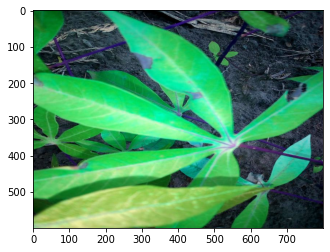

In [62]:
image = cv2.imread('../input/train_images/' + '1773042943.jpg' )
plt.imshow(image)

In [63]:
df = pd.read_csv('../input/train.csv')

In [184]:
names_of_disease

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [223]:
df[df['image_id'] == '2345003518.jpg']

,image_id,label
7552,2345003518.jpg,1


1201690046.jpg


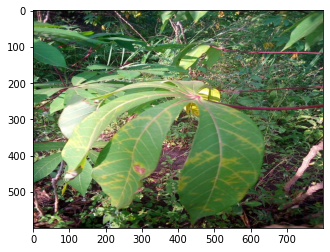

1201703302.jpg


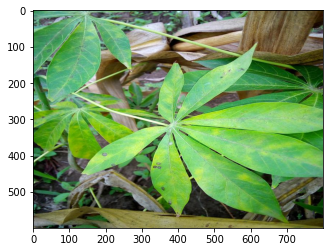

1203115878.jpg


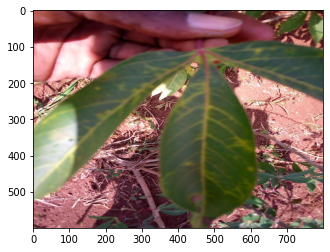

1203118326.jpg


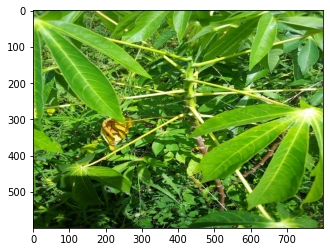

1203248171.jpg


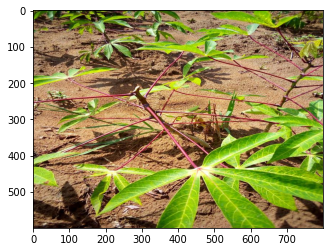

1205478806.jpg


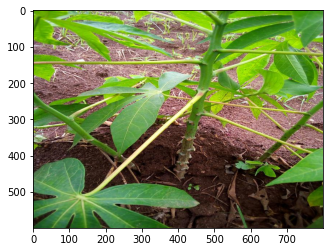

1209108991.jpg


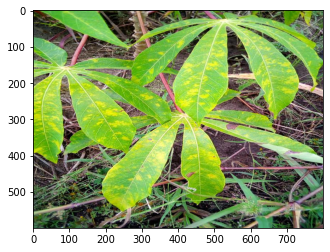

1209157685.jpg


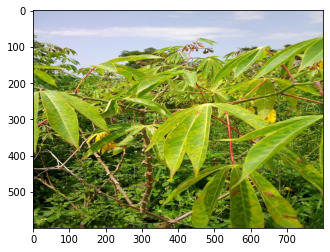

1209868824.jpg


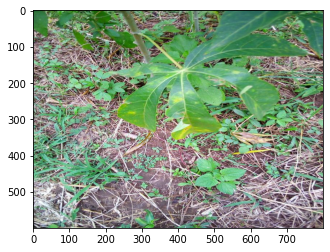

1210657191.jpg


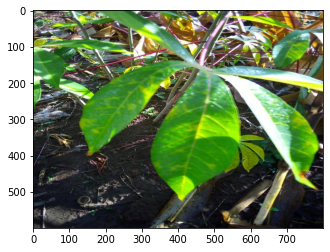

In [243]:
lower = 130
upper = lower + 10
for name in df[df['label'] == 1]['image_id'].to_list()[lower:upper]:
    print(name)
    image = cv2.imread('../input/train_images/' + name )
    image_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.show()

In [244]:
image[0]

array([[233, 254, 216],
       [192, 230, 188],
       [132, 206, 158],
       ...,
       [133, 116, 125],
       [126, 108, 121],
       [118, 101, 114]], dtype=uint8)

In [245]:
image_rgb

array([[[216, 254, 233],
        [188, 230, 192],
        [158, 206, 132],
        ...,
        [125, 116, 133],
        [121, 108, 126],
        [114, 101, 118]],

       [[124, 157, 138],
        [166, 203, 169],
        [143, 188, 123],
        ...,
        [126, 115, 132],
        [118, 104, 121],
        [111,  97, 112]],

       [[ 62,  89,  72],
        [106, 135, 107],
        [147, 181, 131],
        ...,
        [139, 125, 142],
        [124, 106, 122],
        [114,  96, 110]],

       ...,

       [[ 92,  93,  95],
        [ 82,  83,  85],
        [ 66,  67,  69],
        ...,
        [  7,   7,   7],
        [  7,   7,   7],
        [  7,   7,   7]],

       [[ 96,  97,  99],
        [ 88,  89,  91],
        [ 71,  72,  74],
        ...,
        [  5,   5,   5],
        [  6,   6,   6],
        [  7,   7,   7]],

       [[106, 107, 109],
        [107, 108, 110],
        [ 96,  97,  99],
        ...,
        [  3,   3,   3],
        [  4,   4,   4],
        [  6,   6,   6]]

In [69]:
df[df.image_id.isin(yuv_mixed)]['label'].value_counts()

4    495
3    404
1    331
2    327
0    240
Name: label, dtype: int64

In [70]:
df[df.image_id.isin(mixed_precision)]['label'].value_counts()

4    333
3    310
2    239
1    228
0    204
Name: label, dtype: int64

In [72]:
len(preds)

5352

In [73]:
def read_tfrecord(example, labeled=True):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    }

    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = decode_image(example["image"])
    
    if labeled:
        label = tf.cast(example["target"], tf.int32)
        image_name = tf.cast(example["image_name"], tf.string)
        return image, label, image_name
    return image

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32)# / 255.0
    return image
    
    
    
def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=True), num_parallel_calls=AUTOTUNE)
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

# One-hot / categorical encoding
# Resize

def input_preprocess(image, label,image_name):
    image = tf.image.resize(image, size=IMAGE_SIZE)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=255)
    image = tf.image.rgb_to_yuv(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label,image_name


def get_training_dataset(FILENAMES, BATCH_SIZE=12):
    dataset = load_dataset(FILENAMES, labeled=True)  
    dataset = dataset.map(input_preprocess, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
#     dataset = dataset.map(cutmix)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_validation_dataset(FILENAMES, BATCH_SIZE=12):
    dataset = load_dataset(FILENAMES, labeled=True)
    dataset = dataset.map(input_preprocess, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

model_yuv = tf.keras.models.load_model('/home/usmanr/Downloads/EfficientNetB5_yuv_smooting.h5')

In [75]:
train_dataset = get_validation_dataset(VALID_FILENAMES, BATCH_SIZE=120)

In [76]:
# for _ in range(4279//20):
labels_yuv = []
preds_yuv = []
filenames_yuv = []

i = 1
for image, label, filename in train_dataset.take(45):
    labels_yuv+=label.numpy().tolist()
    pred = model_yuv.predict(image)
    preds_yuv+=pred.tolist()
    filenames_yuv+=filename.numpy().tolist()
    print(i)
    i+=1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


In [119]:
preds_rgb = []

for i in range(len(filenames_yuv)):
    for j in range(len(filenames)):
        if filenames_yuv[i] == filenames[j]:
            preds_rgb.append(preds[j])

In [118]:
filenames

[b'100042118.jpg',
 b'1000015157.jpg',
 b'1000201771.jpg',
 b'1000723321.jpg',
 b'1000812911.jpg',
 b'1000837476.jpg',
 b'1000910826.jpg',
 b'1001320321.jpg',
 b'1001723730.jpg',
 b'1001742395.jpg',
 b'1002088496.jpg',
 b'1002255315.jpg',
 b'1001749118.jpg',
 b'100204014.jpg',
 b'1002394761.jpg',
 b'1003218714.jpg',
 b'1003298598.jpg',
 b'1003442061.jpg',
 b'1003888281.jpg',
 b'1003987001.jpg',
 b'1004105566.jpg',
 b'1004163647.jpg',
 b'1004389140.jpg',
 b'1004672608.jpg',
 b'100472565.jpg',
 b'1004826518.jpg',
 b'1004881261.jpg',
 b'1005138819.jpg',
 b'1005200906.jpg',
 b'100533489.jpg',
 b'100560400.jpg',
 b'1005695738.jpg',
 b'1005739807.jpg',
 b'100609661.jpg',
 b'1007196516.jpg',
 b'1007246985.jpg',
 b'100731318.jpg',
 b'1007533812.jpg',
 b'1007700625.jpg',
 b'1007891044.jpg',
 b'1008126487.jpg',
 b'1008142548.jpg',
 b'1008244905.jpg',
 b'1008284502.jpg',
 b'1008532311.jpg',
 b'1009037539.jpg',
 b'1009049118.jpg',
 b'1009126931.jpg',
 b'1009148537.jpg',
 b'1009268848.jpg',
 b'1009

In [127]:
filename[4]

<tf.Tensor: shape=(), dtype=string, numpy=b'1942233808.jpg'>

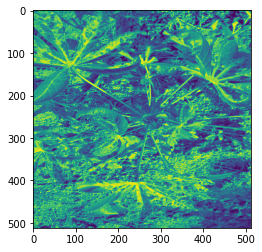

In [126]:
plt.imshow(image[4,:,:,0])

In [96]:
y_label_yuv=[np.argmax(y) for y in labels_yuv]
y_pred_yuv=[np.argmax(y) for y in preds_yuv]

In [97]:
accuracy_score(y_label_yuv, y_pred_yuv)

0.8878923766816144

In [123]:
y_pred_combined = np.array(preds_yuv) + np.array(preds_rgb)

y_pred_combined = [np.argmax(y) for y in y_pred_combined]

In [115]:
np.array(preds_yuv)

array([[0.09022097, 0.56515974, 0.08647182, 0.09442742, 0.16372003],
       [0.18967165, 0.15268344, 0.36742184, 0.09721946, 0.19300352],
       [0.08098417, 0.07565475, 0.09423016, 0.66989684, 0.07923406],
       ...,
       [0.07968387, 0.11140746, 0.16664991, 0.11906028, 0.52319849],
       [0.09508806, 0.06931064, 0.31976983, 0.16216874, 0.35366279],
       [0.09378296, 0.06623682, 0.07220069, 0.67591816, 0.09186144]])

In [120]:
np.array(preds_rgb)

array([[0.08282609, 0.62563616, 0.09093205, 0.10391735, 0.09668835],
       [0.13883488, 0.32246664, 0.39008209, 0.05926401, 0.08935235],
       [0.07333534, 0.07423879, 0.05972571, 0.72858548, 0.06411465],
       ...,
       [0.05326647, 0.08022305, 0.16064717, 0.09355711, 0.61230624],
       [0.07583705, 0.07583942, 0.4181526 , 0.13638787, 0.29378301],
       [0.07795148, 0.07334165, 0.06459552, 0.71797681, 0.06613451]])

In [124]:
y_pred_combined

[1,
 2,
 3,
 3,
 2,
 4,
 3,
 0,
 0,
 3,
 3,
 3,
 1,
 3,
 3,
 2,
 3,
 4,
 4,
 3,
 3,
 3,
 1,
 3,
 2,
 2,
 3,
 3,
 4,
 2,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 1,
 3,
 3,
 3,
 3,
 4,
 1,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 1,
 4,
 3,
 3,
 3,
 3,
 3,
 1,
 2,
 2,
 4,
 4,
 0,
 0,
 3,
 3,
 1,
 3,
 1,
 4,
 3,
 3,
 3,
 4,
 2,
 3,
 3,
 1,
 3,
 3,
 3,
 2,
 2,
 4,
 3,
 3,
 1,
 1,
 2,
 3,
 2,
 4,
 2,
 2,
 4,
 3,
 3,
 1,
 3,
 0,
 3,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 1,
 2,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 0,
 3,
 3,
 4,
 3,
 3,
 2,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 0,
 1,
 2,
 3,
 1,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 4,
 3,
 3,
 1,
 2,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 4,
 1,
 0,
 3,
 3,
 3,
 1,
 2,
 4,
 3,
 4,
 3,
 3,
 3,
 3,
 2,
 4,
 3,
 3,
 2,
 2,
 3,
 3,
 3,
 0,
 3,
 1,
 3,
 3,
 1,
 3,
 3,
 4,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 4,
 0,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 0,
 3,
 4,
 3,
 3,
 3,
 3,


In [125]:
accuracy_score(y_label_yuv, y_pred_combined)

0.8933109118086696